In [1]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
deepp = deep_properties()

## TESTING LISTS WITH NP.ARRAYS

In [2]:
# Example 2D array size!
shape = (2, 2)
deep_id = np.random.randint(1, 12, size=shape)  # Adjust range based on deep_id count
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# Flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# Function to return NumPy arrays inside a NumPy array
def get_layered_data(deep_id_f, key, deepp, is_pF=False):
    """Returns a NumPy array where each entry is a NumPy array of variable length.
    
    If `is_pF=True`, it skips NumPy conversion (since pF is a dictionary).
    """
    deep_id_map = {v['deep_id']: v[key] if is_pF else np.array(v[key], dtype=float) for v in deepp.values()}
    return np.array([deep_id_map.get(d_id, {} if is_pF else np.array([], dtype=float)) for d_id in deep_id_f], dtype=object)

# Assigning values (NumPy arrays inside NumPy array)
deep_zs = get_layered_data(deep_id_f, 'deep_z', deepp)
deep_ksats = get_layered_data(deep_id_f, 'deep_ksat', deepp)
deep_pFs = get_layered_data(deep_id_f, 'pF', deepp, is_pF=True)  # Do not convert to NumPy array yet

# Handling pF parameters separately, ensuring NumPy arrays
def extract_pF_param(deep_pFs, param):
    """Extracts specific pF parameter and ensures NumPy array conversion."""
    return np.array([np.array(v[param], dtype=float) if isinstance(v, dict) else np.array([], dtype=float) for v in deep_pFs], dtype=object)

deep_ThetaS = extract_pF_param(deep_pFs, 'ThetaS')
deep_ThetaR = extract_pF_param(deep_pFs, 'ThetaR')
deep_n = extract_pF_param(deep_pFs, 'n')
deep_alpha = extract_pF_param(deep_pFs, 'alpha')

In [17]:
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [array([ -0.5,  -2.5, -13. ]) array([ -1.2,  -3.8,  -4. , -14.4, -16. ])
 array([ -0.8,  -3. , -14. ]) array([ -0.5,  -2.5, -13. ])]
deep_pFs [{'ThetaS': [0.43, 0.43, 0.43], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2, 1.2, 1.2]}
 {'ThetaS': [0.41, 0.41, 0.41], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}
 {'ThetaS': [0.43, 0.43, 0.43], 'ThetaR': [0.05, 0.05, 0.05], 'alpha': [0.024, 0.024, 0.024], 'n': [1.2, 1.2, 1.2]}]
deep_ksats [array([2.e-06, 2.e-06, 1.e-06])
 array([1.e-07, 3.e-05, 1.e-08, 3.e-05, 1.e-04])
 array([3.e-05, 1.e-08, 1.e-06]) array([2.e-06, 2.e-06, 1.e-06])]


## 2D NP.ARRAYS

In [7]:
# INITIALIZING
max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (2, 2)
deep_id = np.random.randint(1, 4, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# below if pFs need to separated to each param
#deep_ThetaS = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_ThetaR = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_n = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_alpha = np.full((len(deep_id_f), max_nlyrs), np.nan)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        #deep_ThetaS[mask, :nlyrs] = value['pF']['ThetaS']
        #deep_ThetaR[mask, :nlyrs] = value['pF']['ThetaR']
        #deep_n[mask, :nlyrs] = value['pF']['n']
        #deep_alpha[mask, :nlyrs] = value['pF']['alpha']
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']

In [3]:
print('deep_zs', deep_zs)
print('deep_pFs', deep_pFs)
print('deep_ksats', deep_ksats)

deep_zs [[-24.  nan  nan  nan  nan]
 [ -5.  -7. -21.  nan  nan]
 [-29.  nan  nan  nan  nan]
 [-26.  nan  nan  nan  nan]]
deep_pFs [{'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}
 {'ThetaS': [0.89, 0.89, 0.89], 'ThetaR': [0.196, 0.196, 0.196], 'alpha': [0.072, 0.072, 0.072], 'n': [1.255, 1.255, 1.255]}
 {'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}
 {'ThetaS': [0.41], 'ThetaR': [0.05], 'alpha': [0.024], 'n': [1.2]}]
deep_ksats [[1.e-04    nan    nan    nan    nan]
 [1.e-06 1.e-09 1.e-06    nan    nan]
 [1.e-04    nan    nan    nan    nan]
 [1.e-04    nan    nan    nan    nan]]


## NOW TRYING TO VECTORIZE!

### ATTEMPTING TO VECTORIZE THESE FUNCTIONS BELOW :)

In [73]:

def gwl_Wsto(z, pF, Ksat=None, root=False):
    r""" Forms interpolated function for soil column ground water dpeth, < 0 [m], as a
    function of water storage [m] and vice versa + others

    Args:
        - pF (np.ndarrays):
            - dict
                - 'ThetaS' saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'ThetaR' residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
                - 'alpha' air entry suction [cm\ :sup:`-1`]
                - 'n' pore size distribution [-]
        - z (np.ndarrays): soil compartment thichness, node in center [m]
    Returns:
        - (np.ndarray):
            - dict
                - 'to_gwl': interpolated function for gwl(Wsto)
                - 'to_wsto': interpolated function for Wsto(gwl)
                - 'to_C'
                - 'to_Tr'
    """
    dz = abs(z)
    dz[:,1:] = z[:,:-1] - z[:,1:]
    #step = -0.01
    step = -0.05
    z_min = np.nanmin(z, axis=1)
    max_len = int(abs(np.nanmin(z_min)) / abs(step)) + 1
    z_fine = np.tile(np.arange(0, step * max_len, step), (z.shape[0], 1)) + step
    dz_fine = z_fine*0.0 - step
    z_mid_fine = dz_fine / 2 - np.cumsum(dz_fine, axis=1)
    ix = np.full((z_fine.shape), np.nan)
    # Expand z along the second axis to match z_fine's shape (broadcasting)
    z_expanded = np.expand_dims(z, axis=1)  # Shape: (rows, 1, cols)
    z_fine_expanded = np.expand_dims(z_fine, axis=2)  # Shape: (rows, fine_steps, 1)

    # Compute mask using broadcasting (row-wise comparison)
    mask = (z_fine_expanded < z_expanded) & ~np.isclose(z_fine_expanded, z_expanded, atol=1e-9)

    # Sum along the depth dimension to count how many times z_fine falls below z
    ix = np.sum(mask, axis=2).astype(np.float64)  # Convert to float to retain NaN compatibility

    pF_fine = {}

    for key in pF[0].keys():  # Iterate over each parameter in `pF`
        # Convert pF into an array ensuring consistent shapes
        try:
            pF_array = np.vstack([p[key] for p in pF])  # Ensures (rows, depths) shape
        except ValueError:  # If rows have different lengths, handle it gracefully
            max_depth = max(len(p[key]) for p in pF)  # Find the longest row
            pF_array = np.full((len(pF), max_depth), np.nan)  # Initialize padded array

            # Fill rows with actual values
            for i, p in enumerate(pF):
                pF_array[i, :len(p[key])] = p[key]

        # Ensure `ix` values are within valid range (clip to prevent indexing errors)
        ix_valid = np.clip(ix.astype(int), 0, pF_array.shape[1] - 1)

        # Assign values using vectorized indexing
        pF_fine[key] = np.take_along_axis(pF_array, ix_valid, axis=1)  # Shape: (rows, fine_steps)

    # --------- connection between gwl and Wsto, Tr, C------------
    
    # I THINK THE PROBLEM IS THAT WE END UP WITH WRONG SIZE GWL RELATIVE TO THE OTHER ARRAYS
    # TO MAKE THIS WORK, GWL SHOULD BE FOR EACH CELL SEPARATELY AND THEN COMPUTATION OF 
    # H_TO_CELLMOIST AND TRANSMISSIVITY SHOULD BE VECTORIZED AS WELL
    
    z_min = np.nanmin(z, axis=1)
    #z_min_min = np.nanmin(z)
    #gwl = np.arange(1.0, z_min - 5, step)
    #gwl = np.vectorize(lambda z: np.arange(1, z - 5, step) if not np.isnan(z) else np.array([]), otypes=[object])(z_min_min)
    #gwl = np.array(gwl)
    
    # Find the global minimum of z_min, ignoring NaNs
    z_min_min = np.nanmin(z_min)
    # Create the common gwl range
    # step
    #common_gwl = np.arange(1, z_min_min - 5, step)
    common_gwl = np.linspace(1, z_min_min, max_len)

    #max_len = len(common_gwl)
    # Preallocate a 2D array with NaNs
    gwl = np.full((z_min.size, max_len), np.nan)
    # Fill each row with the common gwl values if z_min is not NaN
    valid_mask = ~np.isnan(z_min)
    gwl[valid_mask, :] = common_gwl
   
    Wsto_deep = h_to_cellmoist_2(pF_fine, gwl, z_mid_fine)

    #Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine)
    #        + max(0.0, g) for g in gwl]

    #if root:
    #    Wsto_deep = [sum(h_to_cellmoist(pF_fine, g - z_mid_fine, dz_fine) * dz_fine) for g in gwl]
    #    Wsto_deep = Wsto_deep/sum(dz)
    #    GwlToWsto = interp1d(np.array(gwl), np.array(Wsto_deep), fill_value='extrapolate')
    #    return {'to_rootmoist': GwlToWsto}

    # solve transmissivity corresponding to gwls
    #Tr = [transmissivity(dz, Ksat, g) * 86400. for g in gwl]  # [m2 d-1]

    Tr = transmissivity_2(dz, Ksat, gwl) * 86400
    
    # interpolate functions
    #gwl_2 = np.tile(gwl, (len(Wsto_deep), 1))  # Repeat 601 times along rows
    #Wsto_deep = np.array(Wsto_deep)

    #print('len(Wsto_deep)', len(Wsto_deep))
    #print('len(gwl_2)', len(gwl_2))
    print('Wsto_deep.shape', np.array(Wsto_deep).shape)
    print('gwl.shape', gwl.shape)
    #print('np.gradient(Wsto_deep)/np.gradient(gwl)', np.gradient(Wsto_deep)/np.gradient(gwl)) 

    WstoToGwl = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(Wsto_deep, gwl)]
    GwlToWsto = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(gwl, Wsto_deep)]
    GwlToC = [interp1d(x, y, kind='linear', fill_value='extrapolate') for x, y in zip(gwl, np.gradient(Wsto_deep, axis=1)/np.gradient(gwl, axis=1))]
    
    #WstoToGwl = interp1d(np.array(Wsto_deep), np.array(gwl_2), fill_value='extrapolate')
    #GwlToWsto = interp1d(np.array(gwl_2), np.array(Wsto_deep), fill_value='extrapolate')
    #GwlToC = interp1d(np.array(gwl), np.array(np.gradient(Wsto_deep)/np.gradient(gwl)), fill_value='extrapolate')
    #GwlToTr = interp1d(np.array(gwl), np.array(Tr), fill_value='extrapolate')
    
    #plt.figure(1)
    #plt.plot(np.array(gwl), np.array(np.gradient(Wsto_deep/np.gradient(gwl))))
    #plt.figure(2)
    #plt.plot(np.array(gwl), np.log10(np.array(Tr)))
    #plt.plot(np.array(gwl), np.array(Tr))
    #plt.figure(3)
    #plt.plot(np.array(gwl), np.array(Wsto_deep))
    #return gwl
    return {'to_gwl': WstoToGwl, 'to_wsto': GwlToWsto, 'to_C': GwlToC}#, 'to_Tr': GwlToTr}

def h_to_cellmoist(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' (array): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' (array): air entry suction [cm\ :sup:`-1`]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]

    Kersti Haahti, Luke 8/1/2018
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)
    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def h_to_cellmoist_2(pF, h, dz):
    r""" Cell moisture based on vanGenuchten-Mualem soil water retention model.
    Partly saturated cells calculated as thickness weigthed average of
    saturated and unsaturated parts.

    Args:
        pF (dict):
            'ThetaS' (array): saturated water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'ThetaR' (array): residual water content [m\ :sup:`3` m\ :sup:`-3`\ ]
            'alpha' (array): air entry suction [cm\ :sup:`-1`]
            'n' (array): pore size distribution [-]
        h (array): pressure head [m]
        dz (array): soil conpartment thichness, node in center [m]
    Returns:
        theta (array): volumetric water content of cell [m\ :sup:`3` m\ :sup:`-3`\ ]

    Kersti Haahti, Luke 8/1/2018
    """

    # water retention parameters
    Ts = np.array(pF['ThetaS'])
    Tr = np.array(pF['ThetaR'])
    alfa = np.array(pF['alpha'])
    n = np.array(pF['n'])
    m = 1.0 - np.divide(1.0, n)

    # moisture based on cell center head
    x = np.minimum(h, 0)
    theta = Tr + (Ts - Tr) / (1 + abs(alfa * 100 * x)**n)**m

    # correct moisture of partly saturated cells
    ix = np.where(abs(h) < dz/2)
    if len(Ts) == 1:
        ixx = 0
    else:
        ixx = ix
    # moisture of unsaturated part
    x[ix] = -(dz[ix]/2 - h[ix]) / 2
    theta[ix] = Tr[ixx] + (Ts[ixx] - Tr[ixx]) / (1 + abs(alfa[ixx] * 100 * x[ix])**n[ixx])**m[ixx]
    # total moisture as weighted average
    theta[ix] = (theta[ix] * (dz[ix]/2 - h[ix]) + Ts[ixx] * (dz[ix]/2 + h[ix])) / (dz[ix])

    return theta

def transmissivity(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer.

    Args:
       dz (array):  soil compartment thickness, node in center [m]
       Ksat (array): horizontal saturated hydr. cond. [ms-1]
       gwl (float): ground water level below surface, <0 [m]

    Returns:
       Qz_drain (array): drainage from each soil layer [m3 m-3 s-1]
    """
    # Ensure gwl is properly shaped for broadcasting
    gwl = np.atleast_2d(gwl).T  # Shape: (rows, 1)

    z = dz / 2 - np.cumsum(dz, axis=1)
    Tr = 0.0

    # impermeable bottom
    ib = np.nansum(dz, axis=1, keepdims=True)
    # depth of saturated layer above impermeable bottom
    # Hdr = min(max(0, gwl + ib), ib)  # old
    Hdr = np.maximum(0, gwl + ib)  # not restricted to soil profile -> transmissivity increases when gwl above ground surface level

    """ drainage from saturated layers above ditch base """
    # layers above ditch bottom where drainage is possible
    valid_layers = ((z - dz / 2) - gwl < 0) & ((z + dz / 2) > -ib)  # Boolean mask, shape (rows, layers)
    # Compute saturated thickness per layer
    dz_sat = np.maximum(gwl - (z - dz / 2), 0)  # Shape: (rows, layers)
    # Compute transmissivity per layer
    Trans = Ksat * dz_sat  # Shape: (rows, layers)
    # Identify last saturated layer per row
    last_layer_idx = np.argmax(valid_layers[:, ::-1], axis=1)  # Finds last True from right
    last_layer_idx = valid_layers.shape[1] - 1 - last_layer_idx  # Convert to correct indexing

    # Apply last-layer correction
    dz_sat[np.arange(dz_sat.shape[0]), last_layer_idx] += (
        z[np.arange(z.shape[0]), last_layer_idx] - dz[np.arange(z.shape[0]), last_layer_idx] / 2 + ib.flatten()
    ) * valid_layers[np.arange(valid_layers.shape[0]), last_layer_idx]

    Trans[np.arange(Trans.shape[0]), last_layer_idx] = (
        Ksat[np.arange(Ksat.shape[0]), last_layer_idx] * dz_sat[np.arange(dz_sat.shape[0]), last_layer_idx]
    )

    # Compute transmissivity per row
    Tr = np.sum(Trans * valid_layers, axis=1)

    # Apply minimum threshold to avoid zero transmissivity
    Tr[Tr < 1e-16] = 1e-4 / 86400  # Avoid numerical underflow
    
    return Tr

def transmissivity_2(dz, Ksat, gwl):
    r""" Transmissivity of saturated layer.

    Args:
       dz (array):  soil compartment thickness, node in center [m]
       Ksat (array): horizontal saturated hydr. cond. [ms-1]
       gwl (float): ground water level below surface, <0 [m]

    Returns:
       Qz_drain (array): drainage from each soil layer [m3 m-3 s-1]
    """
    # Ensure gwl is properly shaped for broadcasting
    #gwl = np.atleast_2d(gwl).T  # Shape: (rows, 1)

    # compartment nodes
    z = dz / 2 - np.cumsum(dz, axis=1)

    Tr = np.full(gwl.shape, np.nan)

    # impermeable bottom
    ib = np.nansum(dz, axis=1)[:, np.newaxis] #, keepdims=True)

    # depth of saturated layer above impermeable bottom
    print('gwl.shape', gwl.shape)
    print('dz.shape', dz.shape)
    print('ib.shape', ib.shape)
    print('ib', ib)
    print('z.shape', z.shape)
    
    Hdr = np.maximum(0, gwl + ib)  # not restricted to soil profile -> transmissivity increases when gwl above ground surface level
    dz_sat = np.maximum(gwl - (z - dz / 2), 0)
    Trans = Ksat * dz_sat

    # this is shady
    mask = ((z - dz / 2) - gwl < 0) & ((z + dz / 2) > -ib)
    row_indices, col_indices = np.where(mask)
    ix = [col_indices[row_indices == i] for i in range(mask.shape[0])]
    ix = np.intersect1d(np.where((z - dz / 2) - gwl < 0), np.where(z + dz / 2 > -ib))

    # Convert `ix` from list of arrays to a NumPy array with NaN padding
    max_len = max(len(arr) for arr in ix)  # Get max row length
    ix_padded = np.full((len(ix), max_len), np.nan)  # Initialize with NaN

    # Fill valid indices
    for i, arr in enumerate(ix):
        ix_padded[i, :len(arr)] = arr  # Assign only valid values

    # Convert to integer type, ignoring NaNs
    ix_padded = ix_padded.astype(int)

    # Compute and update `dz_sat` row-wise
    row_idx = np.arange(dz_sat.shape[0])[:, None]  # Row indices for broadcasting
    dz_sat[row_idx, ix_padded[:, -1]] += (z[row_idx, ix_padded[:, -1]] - dz[row_idx, ix_padded[:, -1]] / 2 + ib)
    Trans[row_idx, ix_padded[:, -1]] = Ksat[row_idx, ix_padded[:, -1]] * dz_sat[row_idx, ix_padded[:, -1]]

    # Compute transmissivity per row
    Tr = np.nansum(Trans, axis=1)

    # Apply minimum threshold to avoid zero transmissivity
    Tr[Tr < 1e-16] = 1e-4 / 86400  # Avoid numerical underflow
    
    return Tr

In [ ]:
test = gwl_Wsto(z=deep_zs, pF=deep_pFs, Ksat=deep_ksats)

In [63]:
D2 = True

if D2:
    Ksat = np.array([[1e-5, 1e-4, 1e-6, 1e-7], [1e-3, 1e-6, 1e-7, 1e-5]])
    gwl = np.array([[1, -1, -2, -5], [1, -1, -2, -5]])
    dz = abs(np.array([[-2, -4, -10, -12], [-4, -6, -12, -15]]))
else:
    #Ksat = np.array([1e-5, 1e-4, 1e-6, 1e-7])
    #gwl = np.array([1, -1, -2, -5])
    #dz = abs(np.array([-2, -4, -10, -12]))
    Ksat = np.array([1e-3, 1e-6, 1e-7, 1e-5])
    gwl = np.array([1, -1, -2, -5])
    dz = abs(np.array([-4, -6, -12, -15]))

axis = 1 if dz.ndim == 2 else 0
print('axis', axis)
print('Ksat')
print('gwl', gwl)
print('dz', dz)

z = (dz/2 - np.cumsum(dz, axis=axis))
print('z', z)

Tr = np.full(gwl.shape, np.nan)
print('Tr', Tr)

if D2 == True:
    ib = np.nansum(dz, axis=axis)[:, np.newaxis]
else:
     ib = np.nansum(dz, axis=axis)
   
print('ib', ib)

Hdr = np.maximum(0, gwl + ib)
print('Hdr', Hdr)

dz_sat = np.maximum(gwl - (z - dz / 2), 0)

print('dz_sat', dz_sat)

Trans = Ksat * dz_sat
print('Trans', Trans)

mask = ((z - dz / 2) - gwl < 0) & ((z + dz / 2) > -ib)
print('mask', mask)
if D2:
    row_indices, col_indices = np.where(mask)
    ix = [col_indices[row_indices == i] for i in range(mask.shape[0])]
else:
    ix = np.intersect1d(np.where((z - dz / 2) - gwl < 0), np.where(z + dz / 2 > -ib))
print('ix', ix)

if D2:
    # Convert `ix` from list of arrays to a NumPy array with NaN padding
    max_len = max(len(arr) for arr in ix)  # Get max row length
    ix_padded = np.full((len(ix), max_len), np.nan)  # Initialize with NaN

    # Fill valid indices
    for i, arr in enumerate(ix):
        ix_padded[i, :len(arr)] = arr  # Assign only valid values

    # Convert to integer type, ignoring NaNs
    ix_padded = ix_padded.astype(int)

    # Compute and update `dz_sat` row-wise
    row_idx = np.arange(dz_sat.shape[0])[:, None]  # Row indices for broadcasting
    dz_sat[row_idx, ix_padded[:, -1]] += (z[row_idx, ix_padded[:, -1]] - dz[row_idx, ix_padded[:, -1]] / 2 + ib)
else:
    dz_sat[ix[-1]] = dz_sat[ix[-1]] + (z[ix][-1] - dz[ix][-1] / 2 + ib)
print('dz_sat', dz_sat)

axis 1
Ksat
gwl [[ 1 -1 -2 -5]
 [ 1 -1 -2 -5]]
dz [[ 2  4 10 12]
 [ 4  6 12 15]]
z [[ -1.   -4.  -11.  -22. ]
 [ -2.   -7.  -16.  -29.5]]
Tr [[nan nan nan nan]
 [nan nan nan nan]]
ib [[28]
 [37]]
Hdr [[29 27 26 23]
 [38 36 35 32]]
dz_sat [[ 3.  5. 14. 23.]
 [ 5.  9. 20. 32.]]
Trans [[3.0e-05 5.0e-04 1.4e-05 2.3e-06]
 [5.0e-03 9.0e-06 2.0e-06 3.2e-04]]
mask [[ True  True  True  True]
 [ True  True  True  True]]
ix [array([0, 1, 2, 3]), array([0, 1, 2, 3])]
dz_sat [[ 3.  5. 14. 23.]
 [ 5.  9. 20. 32.]]


gwl.shape (10000, 601)
dz.shape (10000, 5)
ib.shape (10000, 1)
ib [[27.]
 [28.]
 [24.]
 ...
 [26.]
 [21.]
 [21.]]
z.shape (10000, 5)


ValueError: operands could not be broadcast together with shapes (10000,601) (10000,5) 

In [59]:
test

{'to_gwl': [<scipy.interpolate._interpolate.interp1d at 0x15a1f8d70>,
 'to_wsto': [<scipy.interpolate._interpolate.interp1d at 0x15d2b3160>,
 'to_C': [<scipy.interpolate._interpolate.interp1d at 0x15a1997c0>,
  <scipy.interpolate._interpolate.interp1d at 0x15a198870>]}

## THIS IS WITHOUT VECTORIZATION, FOR LOOPS

In [1]:
from soilprofile2D import gwl_Wsto as gwl_Wsto_old
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from parameters_krycklan import deep_properties
import sys
deepp = deep_properties()

max_nlyrs = 0
for key, value in deepp.items():
    nlyrs = len(value['deep_z'])
    max_nlyrs = max(max_nlyrs, nlyrs)

# 2D array size!
shape = (100, 100)
deep_id = np.random.randint(1, 4, size=shape)
deep_z = np.random.randint(-30, -20, size=shape)
gridshape = np.ones(shape=deep_id.shape)

# flattening for processing
deep_id_f = deep_id.flatten()
deep_z_f = deep_z.flatten()

# creating the arrays
deep_zs = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_ksats = np.full((len(deep_id_f), max_nlyrs), np.nan)
deep_pFs = np.empty(len(deep_id_f), dtype=object)
# below if pFs need to separated to each param
#deep_ThetaS = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_ThetaR = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_n = np.full((len(deep_id_f), max_nlyrs), np.nan)
#deep_alpha = np.full((len(deep_id_f), max_nlyrs), np.nan)
# interpolation functions
deep_ifs = np.empty(shape=[len(deep_id_f)], dtype=object)
deep_ifs_root = np.empty(shape=[len(deep_id_f)], dtype=object)
# each interpolation function separately
wtso_to_gwl = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_wsto = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_C = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_Tr = np.empty(shape=[len(deep_id_f)], dtype=object)
gwl_to_rootmoist = np.empty(shape=[len(deep_id_f)], dtype=object)

# making parametes into 2D arrays (total length and layered information)
for key, value in deepp.items():
    mask = deep_id_f == value['deep_id']
    if np.any(mask):  # Only proceed if at least one match
        nlyrs = len(value['deep_z'])
        deep_zs[mask, :nlyrs] = value['deep_z']
        deep_zs[mask, nlyrs - 1] = deep_z_f[mask]  # Replace last layer
        #deep_ThetaS[mask, :nlyrs] = value['pF']['ThetaS']
        #deep_ThetaR[mask, :nlyrs] = value['pF']['ThetaR']
        #deep_n[mask, :nlyrs] = value['pF']['n']
        #deep_alpha[mask, :nlyrs] = value['pF']['alpha']
        deep_ksats[mask, :nlyrs] = value['deep_ksat']
        deep_pFs[mask] = value['pF']

In [2]:
ifs = gwl_Wsto_old(deep_zs[0][:3], deep_pFs[0], deep_ksats[0][0:3])

dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0.2]
z [-0.6 -2.5 -3.9]
ix [0 1 2]
dz [1.2 2.6 0

In [5]:
for i in range(len(deep_id_f)):
    if isinstance(deep_pFs[i], dict):  # Ensure it's valid before calling gwl_Wsto
        deep_ifs[i] = gwl_Wsto_old(deep_zs[i], deep_pFs[i], deep_ksats[i])
        deep_ifs_root[i] = gwl_Wsto_old(deep_zs[i][:2], 
                                    {k: deep_pFs[i][k][:2] for k in deep_pFs[i]}, 
                                    root=True)

        wtso_to_gwl[i] = deep_ifs[i]['to_gwl']
        gwl_to_wsto[i] = deep_ifs[i]['to_wsto']
        gwl_to_C[i] = deep_ifs[i]['to_C']
        gwl_to_Tr[i] = deep_ifs[i]['to_Tr']
        gwl_to_rootmoist[i] = deep_ifs_root[i]['to_rootmoist']

wtso_to_gwl = wtso_to_gwl.reshape(deep_id.shape)
gwl_to_wsto = gwl_to_wsto.reshape(deep_id.shape)
gwl_to_C = gwl_to_C.reshape(deep_id.shape)
gwl_to_Tr = gwl_to_Tr.reshape(deep_id.shape)
gwl_to_rootmoist = gwl_to_rootmoist.reshape(deep_id.shape)

In [10]:
ifs

{'to_gwl': <scipy.interpolate._interpolate.interp1d at 0x16a7e0050>,
 'to_wsto': <scipy.interpolate._interpolate.interp1d at 0x16a413a20>,
 'to_C': <scipy.interpolate._interpolate.interp1d at 0x16a4122b0>,
 'to_Tr': <scipy.interpolate._interpolate.interp1d at 0x103699860>}

In [66]:
# testing interpolation functions
gwl =  np.linspace(-1, -20, num=3000)
Wsto = np.linspace(50, 80, num=3000)

x_new = np.linspace(52, 80, num=10000)  # New x-values

In [67]:
ys = interp1d(Wsto, gwl, fill_value='extrapolate')

In [68]:
ys(x_new)

array([ -2.26666667,  -2.26844018,  -2.27021369, ..., -19.99645298,
       -19.99822649, -20.        ])

In [69]:
np.interp(x_new, Wsto, gwl)

array([ -2.26666667,  -2.26844018,  -2.27021369, ..., -19.99645298,
       -19.99822649, -20.        ])

In [32]:
ys(10)

array(39.611389)

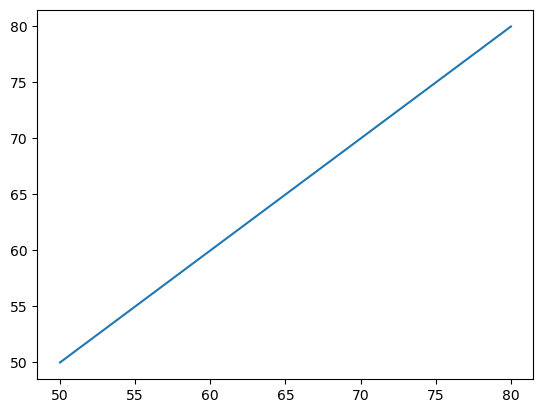

In [35]:
plt.plot(Wsto, Wsto)